# Implementing a Neural Network From Scratch with NumPy

## Setup

In [12]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from single_neuron_funcs import *
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

## Load Tox21 Dataset

This data is from the Tox21 Data Challenge 2014 -- Nuclear Receptor Signaling Panel **AR Assay** found here:

https://tripod.nih.gov/tox21/challenge/data.jsp#

In [2]:
# Load data
df = pd.read_csv('../nr-ar.smiles', sep='\t', header=None).dropna()

# Rename columns
df.columns = ['Smiles', 'ID', 'Active']

# Add fingerprints
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize = 2048)
df['mol'] = df.Smiles.apply(Chem.MolFromSmiles)
df.dropna(inplace = True)
df['fingerprint'] = df.mol.apply(lambda x: np.array(mfpgen.GetFingerprint(x)))

df

[22:40:04] Explicit valence for atom # 0 Cl, 1, is greater than permitted
[22:40:04] Explicit valence for atom # 2 Cl, 1, is greater than permitted
[22:40:04] WARNING: not removing hydrogen atom without neighbors


,Smiles,ID,Active,mol,fingerprint
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...
9357,CCCC1=CC(=O)NC(=S)N1,NCGC00259290-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004D...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9358,S=C1NCCN1,NCGC00258846-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9359,S=C1NCCN1,NCGC00254936-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9360,CCOP(=S)(OCC)OC1=CC=C(C=C1)[N+]([O-])=O,NCGC00254571-01,0,<rdkit.Chem.rdchem.Mol object at 0x000002C004D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Create Train/Test/Val Splits

I am just using a random split in this case. 


80/10/10

In [3]:
#Shuffle dataframe rows
df = df.sample(frac=1, random_state=42).reset_index().drop(columns=['index', 'Smiles', 'mol'])

# Make train/test/val splits
num_samples = len(df)
train_cutoff = int(num_samples*0.8)
test_cutoff = int(num_samples*0.9)
df_train = df[0:train_cutoff]
df_test = df[train_cutoff:test_cutoff]
df_val = df[test_cutoff:]

## Neural Net

In [4]:
df_train

,ID,Active,fingerprint
0,NCGC00254542-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,NCGC00093759-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,NCGC00183843-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,NCGC00258736-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,NCGC00256003-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
7483,NCGC00016580-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7484,NCGC00017043-02,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7485,NCGC00160377-01,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7486,NCGC00255635-01,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


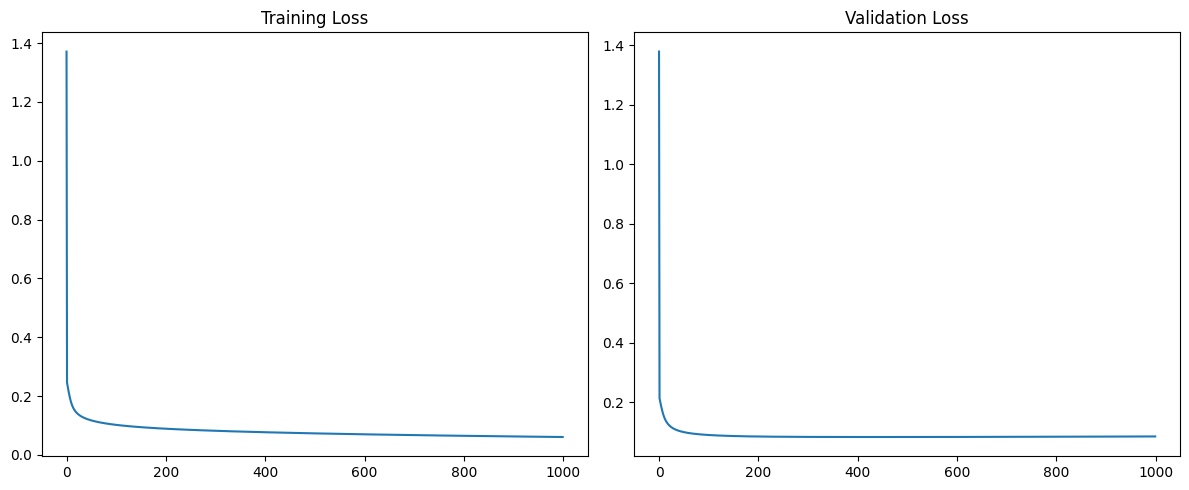

In [5]:
# Initialize weights and bias
weights = np.random.random(2048)/100
bias = 1
num_epochs = 1000

all_losses = []
biases = []
all_losses_val = []

# Train data
X = df_train['fingerprint'].to_list()
y = np.array(df_train['Active'].to_list())

# Val data
X_val = df_val['fingerprint'].to_list()
y_val = np.array(df_val['Active'].to_list())

for i in tqdm(range(num_epochs)):

    # Compute weighted sums
    zs = weighted_sum(X, weights, bias)

    # Sigmoid activation function and classify data
    cutoff = 0.5
    probs = np.array(sigmoid(zs))
    preds = np.array([1 if z >= 0.5 else 0 for z in zs])

    # Compute train losses
    losses = bce(ground_truths=y, predicted_probabilities=probs)
    epoch_loss = np.mean(losses)
    all_losses.append(epoch_loss)
    biases.append(bias)

    # Compute gradients
    dL_dweights = np.mean((probs - y).reshape(-1,1) * np.stack(X), axis=0)
    dL_db = np.mean(probs - y)
    
    # Compute val loss
    zs_val = weighted_sum(X_val, weights, bias)
    probs_val = np.array(sigmoid(zs_val))
    preds_val = np.array([1 if z >= 0.5 else 0 for z in zs_val])
    losses_val = bce(ground_truths=y_val, predicted_probabilities=probs_val)
    epoch_loss_val = np.mean(losses_val)
    all_losses_val.append(epoch_loss_val)
    
    # Update rates
    learning_rate = 1.2
    weights = weights - learning_rate*dL_dweights
    bias = bias - learning_rate*dL_db



# Plot training loss and validation loss
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.lineplot(data=all_losses, ax=axs[0])
axs[0].set_title('Training Loss')

sns.lineplot(data=all_losses_val, ax=axs[1])
axs[1].set_title('Validation Loss')

plt.tight_layout()
plt.show()


<Axes: >

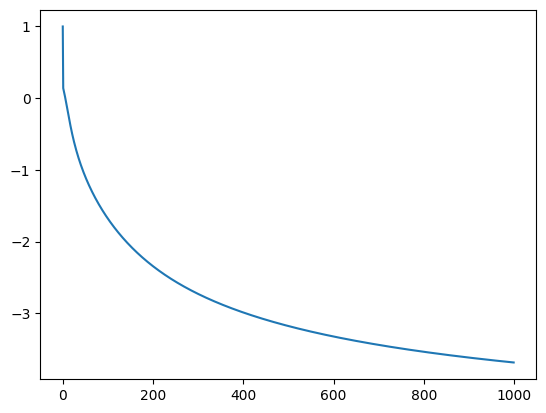

In [6]:
sns.lineplot(biases)

Precision: 0.9823529411764705
Recall: 0.5422077922077922
F1: 0.698744769874477


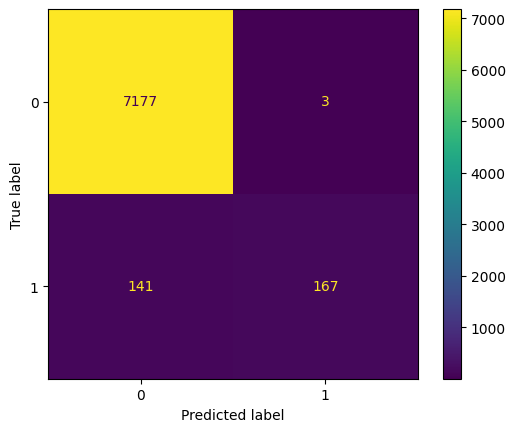

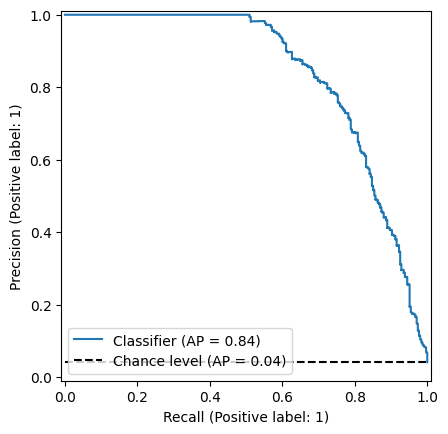

In [7]:
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc, precision_recall_curve

precision, recall, thresholds = metrics.precision_recall_curve(y_true = y, y_score=probs)

ConfusionMatrixDisplay.from_predictions(y, preds)
PrecisionRecallDisplay.from_predictions(y, probs, plot_chance_level=True)
print(f'Precision: {precision_score(y, preds, zero_division=np.nan)}')
print(f'Recall: {recall_score(y, preds, zero_division=np.nan)}')
print(f'F1: {f1_score(y, preds, zero_division=np.nan)}')

## Test Data

Precision: 1.0
Recall: 0.47619047619047616
F1: 0.6451612903225806


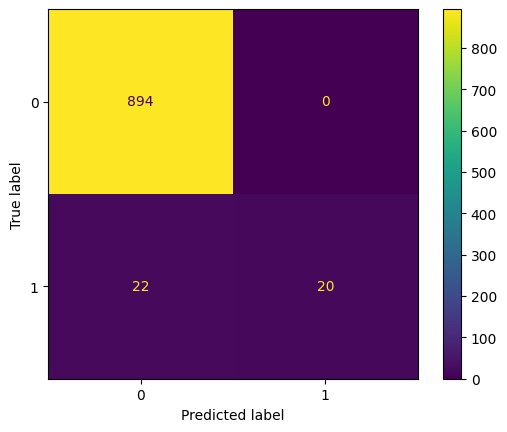

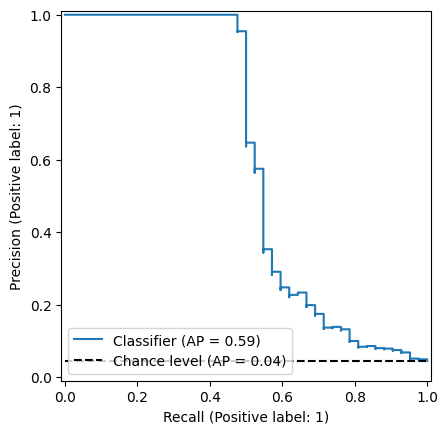

In [8]:
X = df_test['fingerprint'].to_list()
y = np.array(df_test['Active'].to_list())


zs = weighted_sum(X, weights, bias)

cutoff = 0.5
probs = np.array(sigmoid(zs))
preds = np.array([1 if z >= 0.5 else 0 for z in zs])

precision, recall, thresholds = metrics.precision_recall_curve(y_true = y, y_score=probs)

ConfusionMatrixDisplay.from_predictions(y, preds)
PrecisionRecallDisplay.from_predictions(y, probs, plot_chance_level=True)
print(f'Precision: {precision_score(y, preds, zero_division=np.nan)}')
print(f'Recall: {recall_score(y, preds, zero_division=np.nan)}')
print(f'F1: {f1_score(y, preds, zero_division=np.nan)}')